In [1]:
import pandas as pd
import re
import emoji
import contractions
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from gensim.models import LdaModel, CoherenceModel
from gensim.corpora import Dictionary
from tqdm import tqdm

# Download NLTK stuff
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eliza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\eliza\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eliza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eliza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:

# Load preprocessed data
df = pd.read_csv("preprocessing.csv")

# Convert stringified lists back to actual token lists
from ast import literal_eval
df["tokens"] = df["tokens"].apply(literal_eval)

# Filter again (just in case)
df = df[df["tokens"].str.len() >= 3]

processed_texts = df["tokens"].tolist()

dictionary = Dictionary(processed_texts)
dictionary.filter_extremes(no_below=10, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in processed_texts]



C:\Users\eliza\AppData\Local\Temp\ipykernel_9164\201006513.py:2: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("preprocessing.csv")


In [3]:
coherence_scores = {
    'c_v': [],
    'u_mass': [],
    'c_uci': [],
    'c_npmi': []
}

k_values = list(range(10, 150, 10))  # 10 to 140

for k in tqdm(k_values, desc="Loading & Evaluating Models"):
    model = LdaModel.load(f"lda_model_k{k}.model")
    
    for metric in coherence_scores:
        cm = CoherenceModel(
            model=model,
            texts=processed_texts,
            dictionary=dictionary,
            corpus=corpus if metric == 'u_mass' else None,
            coherence=metric
        )
        coherence_scores[metric].append(cm.get_coherence())


Loading & Evaluating Models: 100%|██████████| 14/14 [1:53:23<00:00, 485.94s/it]


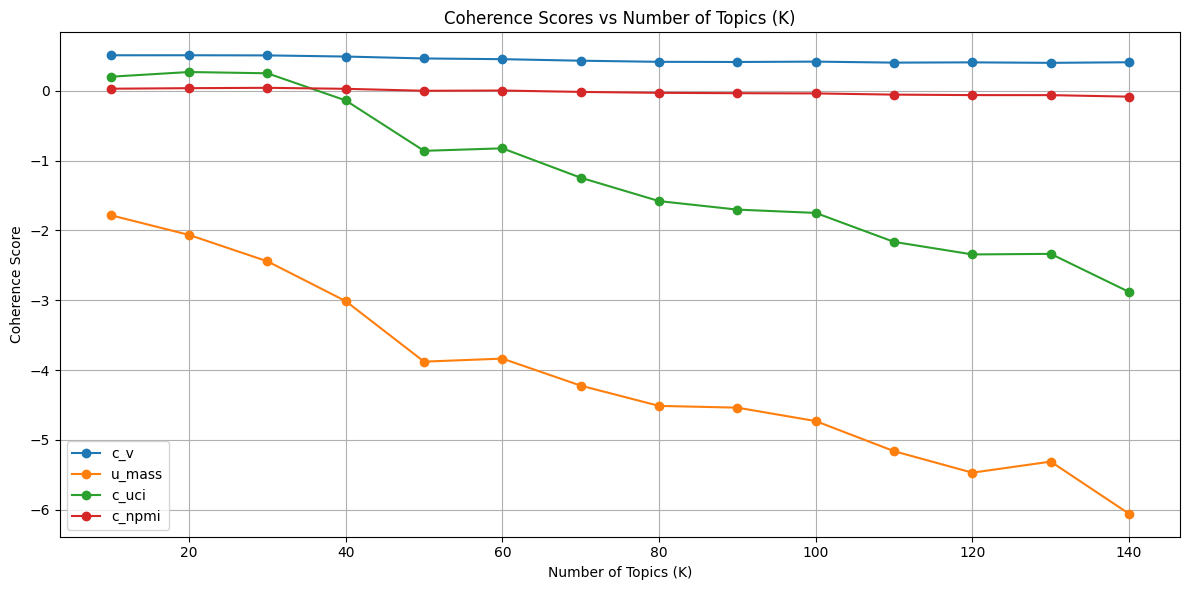

In [4]:
plt.figure(figsize=(12, 6))

for metric, scores in coherence_scores.items():
    plt.plot(k_values, scores, marker='o', label=metric)

plt.title("Coherence Scores vs Number of Topics (K)")
plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [5]:


for i, k in enumerate(k_values):
    print(f"\nK = {k}")
    for metric in coherence_scores:
        print(f"   {metric}: {coherence_scores[metric][i]:.4f}")


K = 10
   c_v: 0.5099
   u_mass: -1.7810
   c_uci: 0.2030
   c_npmi: 0.0310

K = 20
   c_v: 0.5103
   u_mass: -2.0634
   c_uci: 0.2702
   c_npmi: 0.0388

K = 30
   c_v: 0.5083
   u_mass: -2.4415
   c_uci: 0.2520
   c_npmi: 0.0439

K = 40
   c_v: 0.4919
   u_mass: -3.0120
   c_uci: -0.1370
   c_npmi: 0.0296

K = 50
   c_v: 0.4644
   u_mass: -3.8789
   c_uci: -0.8588
   c_npmi: 0.0015

K = 60
   c_v: 0.4543
   u_mass: -3.8356
   c_uci: -0.8231
   c_npmi: 0.0051

K = 70
   c_v: 0.4322
   u_mass: -4.2226
   c_uci: -1.2441
   c_npmi: -0.0149

K = 80
   c_v: 0.4162
   u_mass: -4.5129
   c_uci: -1.5791
   c_npmi: -0.0279

K = 90
   c_v: 0.4141
   u_mass: -4.5383
   c_uci: -1.7010
   c_npmi: -0.0332

K = 100
   c_v: 0.4192
   u_mass: -4.7306
   c_uci: -1.7484
   c_npmi: -0.0364

K = 110
   c_v: 0.4047
   u_mass: -5.1618
   c_uci: -2.1636
   c_npmi: -0.0536

K = 120
   c_v: 0.4086
   u_mass: -5.4698
   c_uci: -2.3431
   c_npmi: -0.0606

K = 130
   c_v: 0.4017
   u_mass: -5.3111
   c_uci: -2.33

# **TOPIC DIVERSITY**

In [1]:
import pandas as pd
from gensim.corpora import Dictionary
from ast import literal_eval

df = pd.read_csv("preprocessing.csv")
df["tokens"] = df["tokens"].apply(literal_eval)
df = df[df["tokens"].str.len() >= 3]
processed_texts = df["tokens"].tolist()
dictionary = Dictionary(processed_texts)
dictionary.filter_extremes(no_below=10, no_above=0.5)


C:\Users\eliza\AppData\Local\Temp\ipykernel_27488\1142117361.py:5: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("preprocessing.csv")


In [2]:
from gensim.models import LdaModel
from tqdm import tqdm

def compute_topic_diversity(model, topk=10):
    topic_words = [list(zip(*model.show_topic(topic_id, topn=topk)))[0] for topic_id in range(model.num_topics)]
    all_words = [word for topic in topic_words for word in topic]
    unique_words = set(all_words)
    return len(unique_words) / len(all_words)


In [3]:
k_values = list(range(10, 150, 10))
topic_diversities = []

for k in tqdm(k_values, desc="Computing Topic Diversity"):
    model = LdaModel.load(f"lda_model_k{k}.model")
    diversity = compute_topic_diversity(model, topk=10)
    topic_diversities.append(diversity)


Computing Topic Diversity: 100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


In [4]:
for k, diversity in zip(k_values, topic_diversities):
    print(f"K = {k:<3} → Topic Diversity: {diversity:.4f}")

K = 10  → Topic Diversity: 0.6800
K = 20  → Topic Diversity: 0.6300
K = 30  → Topic Diversity: 0.6800
K = 40  → Topic Diversity: 0.6700
K = 50  → Topic Diversity: 0.7260
K = 60  → Topic Diversity: 0.7400
K = 70  → Topic Diversity: 0.7757
K = 80  → Topic Diversity: 0.8050
K = 90  → Topic Diversity: 0.8078
K = 100 → Topic Diversity: 0.8070
K = 110 → Topic Diversity: 0.8191
K = 120 → Topic Diversity: 0.8408
K = 130 → Topic Diversity: 0.8146
K = 140 → Topic Diversity: 0.8271


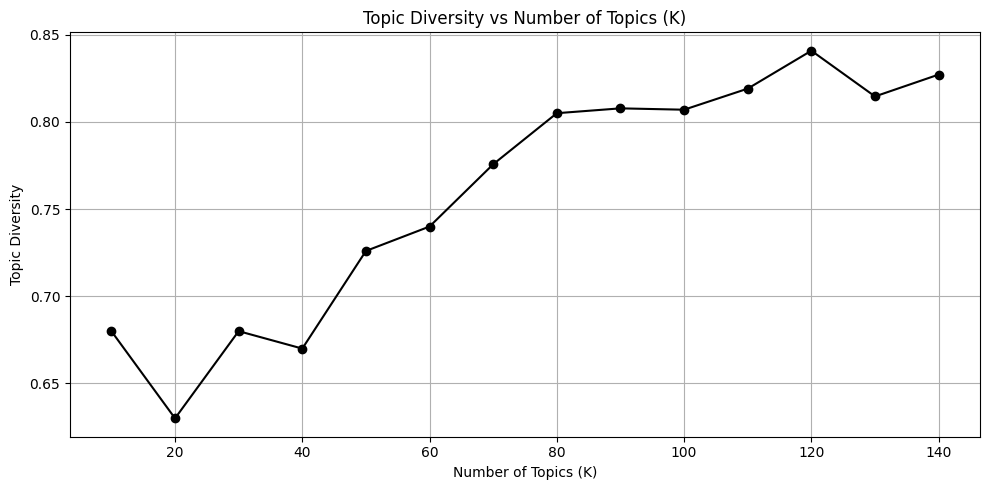

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(k_values, topic_diversities, marker='o', color='black')
plt.title("Topic Diversity vs Number of Topics (K)")
plt.xlabel("Number of Topics (K)")
plt.ylabel("Topic Diversity")
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
df

,user_id,username,time,rating,original_text,translated_text,final_with_stopword,final_no_stopword,ori_wc,final_wc,...,category_13,category_14,category_15,category_16,category_17,category_18,category_19,category_20,category_21,tokens
0,1.144028e+20,Sajida Dar,1583977664092,5.0,"Great people,great staff and great facility to...","Great people,great staff and great facility to...",great people great staff and great facility to...,great people great staff great facility go thu...,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[great, people, great, staff, great, facility,..."
1,1.027817e+20,Tamara Walker,1604380776309,2.0,Security guard asked me to put a mask on my 13...,Security guard asked me to put a mask on my 13...,security guard ask me to put a mask on my 13 m...,security guard ask put mask 13 month old baby ...,65,68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[security, guard, ask, put, mask, month, old, ..."
2,1.147746e+20,Christina Veres,1560489213707,4.0,One of the better Cub foods that I have shoppe...,One of the better Cub foods that I have shoppe...,one of the good cub food that i have shop at e...,one good cub food shop everything need right e...,39,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[one, good, cub, food, shop, everything, need,..."
3,1.108501e+20,Keegan Leahy,1581384638564,1.0,Front of house has amazing staff.. Owner howev...,Front of house has amazing staff.. Owner howev...,front of house have amazing staff owner howeve...,front house amazing staff owner however lot gr...,51,51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[front, house, amazing, staff, owner, however,..."
4,1.106635e+20,Kyle Ebert,1592438884887,2.0,Came in early\nNo one was there except one per...,Came in early\nNo one was there except one per...,come in early no one be there except one perso...,come early no one except one person need simpl...,60,62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[come, early, one, except, one, person, need, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316339,1.020788e+20,Kevin Portee,1577891990033,5.0,I feel like a new person on every visit,I feel like a new person on every visit,i feel like a new person on every visit,feel like new person every visit,9,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[feel, like, new, person, every, visit]"
316340,1.143790e+20,James Rose,1522868195876,5.0,The aqua therapy I have been receiving there h...,The aqua therapy I have been receiving there h...,the aqua therapy i have be receive there have ...,aqua therapy receive helpful,12,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[aqua, therapy, receive, helpful]"
316341,1.015381e+20,Maxwell Rosa,1540950220650,5.0,Had baby #1 last year in June. Staff was amaz...,Had baby #1 last year in June. Staff was amaz...,have baby 1 last year in june staff be amaze s...,baby 1 last year june staff amaze shoutout mid...,30,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[baby, last, year, june, staff, amaze, shoutou..."
316342,1.028744e+20,Yolonda Taylor,1536770366671,1.0,I gave the staff my authorization number for m...,I gave the staff my authorization number for m...,i give the staff my authorization number for m...,give staff authorization number botox injectio...,116,119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[give, staff, authorization, number, botox, in..."


# **TOPIC DETAILS**

**TOPIC INSPECTION**

In [7]:
from gensim.models import LdaModel

# choose model u want to inspect
k = 20  
model = LdaModel.load(f"lda_model_k{k}.model")

#print top n words per topic

topn = 10  # number of words per topic

for topic_id in range(model.num_topics):
    words = model.show_topic(topic_id, topn=topn)
    words_str = ", ".join([word for word, _ in words])
    print(f"Topic {topic_id+1}: {words_str}")


Topic 1: insurance, pay, bill, charge, would, tell, get, go, money, company
Topic 2: front, ask, say, desk, lady, rude, like, talk, know, question
Topic 3: room, go, get, hour, come, test, wait, nurse, back, tell
Topic 4: love, dr, best, go, kid, year, always, staff, great, family
Topic 5: pain, help, back, therapy, massage, work, therapist, physical, surgery, get
Topic 6: care, patient, doctor, medical, clinic, health, need, visit, urgent, nurse
Topic 7: call, get, phone, prescription, pharmacy, back, time, tell, answer, day
Topic 8: staff, friendly, great, nice, professional, helpful, experience, always, recommend, service
Topic 9: appointment, call, schedule, day, tell, get, make, office, would, time
Topic 10: dentist, dental, teeth, go, get, tooth, cleaning, need, work, do
Topic 11: wait, time, hour, minute, long, see, doctor, take, appointment, get
Topic 12: service, customer, bad, rude, ever, staff, experience, never, place, horrible
Topic 13: feel, make, like, comfortable, felt,

In [10]:
#format into dataframe
import pandas as pd

topics = []
for topic_id in range(model.num_topics):
    top_words = [word for word, _ in model.show_topic(topic_id, topn=topn)]
    topics.append(top_words)

k20 = pd.DataFrame(topics, columns=[f"Word_{i+1}" for i in range(topn)])
k20.index = [f"Topic_{i+1}" for i in range(model.num_topics)]
k20


,Word_1,Word_2,Word_3,Word_4,Word_5,Word_6,Word_7,Word_8,Word_9,Word_10
Topic_1,insurance,pay,bill,charge,would,tell,get,go,money,company
Topic_2,front,ask,say,desk,lady,rude,like,talk,know,question
Topic_3,room,go,get,hour,come,test,wait,nurse,back,tell
Topic_4,love,dr,best,go,kid,year,always,staff,great,family
Topic_5,pain,help,back,therapy,massage,work,therapist,physical,surgery,get
Topic_6,care,patient,doctor,medical,clinic,health,need,visit,urgent,nurse
Topic_7,call,get,phone,prescription,pharmacy,back,time,tell,answer,day
Topic_8,staff,friendly,great,nice,professional,helpful,experience,always,recommend,service
Topic_9,appointment,call,schedule,day,tell,get,make,office,would,time
Topic_10,dentist,dental,teeth,go,get,tooth,cleaning,need,work,do


In [11]:
k20.to_csv("TOPIC_KEYWORD_20.csv", index = False)

In [12]:
import pandas as pd
from ast import literal_eval
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# Load preprocessed file
df = pd.read_csv("preprocessing.csv")
df["tokens"] = df["tokens"].apply(literal_eval)

# Prepare corpus
dictionary = Dictionary(df["tokens"])
dictionary.filter_extremes(no_below=10, no_above=0.5)
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens"]]
#REPLACE THIS NUMBER!!
k = 20
model = LdaModel.load(f"lda_model_k{k}.model")
# Compute topic distributions for each review
topic_distributions = []
dominant_topics = []

for doc_bow in corpus:
    dist = model.get_document_topics(doc_bow, minimum_probability=0.0)
    topic_distributions.append(dist)
    
    # Get topic with highest probability
    dominant_topic = max(dist, key=lambda x: x[1])[0]
    dominant_topics.append(dominant_topic)

# Add to dataframe
df[f"topic_dist_k{k}"] = topic_distributions
df[f"dominant_topic_k{k}"] = dominant_topics
df

C:\Users\eliza\AppData\Local\Temp\ipykernel_27488\3555798755.py:7: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("preprocessing.csv")


IndexError: index 14890 is out of bounds for axis 1 with size 14890

**RETRAIN THE MODEL WITH THE BEST K BECAUSE THE DICTIONARY WASNT SAVED**

In [13]:
import pandas as pd
import re
import emoji
import contractions
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel
from tqdm import tqdm

# Download once only
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

# Load and preprocess
df = pd.read_csv("C:/Users/eliza/Documents/Semester VI/ELIZA SEMANGAT/medical_data.csv")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(tag):
    if tag.startswith('J'): return wordnet.ADJ
    elif tag.startswith('V'): return wordnet.VERB
    elif tag.startswith('N'): return wordnet.NOUN
    elif tag.startswith('R'): return wordnet.ADV
    return wordnet.NOUN

def preprocess(text):
    if not isinstance(text, str): return []
    text = contractions.fix(text)
    text = emoji.replace_emoji(text, '')
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\S+@\S+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    return [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in tagged
        if word not in stop_words and len(word) > 1 and word.isalpha()
    ]

# Apply preprocessing
df["tokens"] = df["translated_text"].apply(preprocess)
df = df[df["tokens"].str.len() >= 3]
df.to_csv("FINAL_preprocessed_20.csv", index=False)  

processed_texts = df["tokens"].tolist()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eliza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\eliza\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eliza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eliza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\eliza\AppData\Local\Temp\ipykernel_27488\1995436291.py:21: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/eliza/Documents/Semester VI/ELIZA SEMANGAT/medical_data.csv")


**create dictionary and save corpus**

In [14]:
from gensim.corpora import MmCorpus

dictionary = Dictionary(processed_texts)
dictionary.filter_extremes(no_below=10, no_above=0.5)
dictionary.save("FINAL_dictionary_20.dict")  #!!!

corpus = [dictionary.doc2bow(text) for text in processed_texts]
MmCorpus.serialize("FINAL_corpus_20.mm", corpus)  #!!!



In [15]:
print(f"Number of unique tokens: {len(dictionary)}")
print(f"Number of documents: {len(corpus)}")

Number of unique tokens: 14890
Number of documents: 310440


In [16]:
model = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=20,
    random_state=42,
    chunksize=512,
    passes=10,
    workers=8
)
model.save("FINAL_model_k20.model")  # !!!


In [17]:
# Compute all coherence metrics
coherence_scores = {}
for metric in ['c_v', 'u_mass', 'c_uci', 'c_npmi']:
    cm = CoherenceModel(
        model=model,
        texts=processed_texts,
        dictionary=dictionary,
        corpus=corpus if metric == 'u_mass' else None,
        coherence=metric
    )
    coherence_scores[metric] = cm.get_coherence()

# Compute topic diversity
def compute_topic_diversity(model, topk=10):
    topic_words = [list(zip(*model.show_topic(i, topn=topk)))[0] for i in range(model.num_topics)]
    all_words = [word for topic in topic_words for word in topic]
    unique_words = set(all_words)
    return len(unique_words) / len(all_words)

topic_diversity = compute_topic_diversity(model, topk=10)

# Save scores
with open("FINAL_model_k20_metrics.txt", "w") as f:
    for k, v in coherence_scores.items():
        f.write(f"{k}: {v:.4f}\n")
    f.write(f"topic_diversity: {topic_diversity:.4f}\n")


In [18]:
import pandas as pd
from gensim.models import LdaModel
from gensim.corpora import Dictionary, MmCorpus
from ast import literal_eval

# Load preprocessed review file
df = pd.read_csv("FINAL_preprocessed_20.csv")
df["tokens"] = df["tokens"].apply(literal_eval)

# Load dictionary and corpus used for model training
dictionary = Dictionary.load("FINAL_dictionary_20.dict")
corpus = MmCorpus("FINAL_corpus_20.mm")

# Load trained model
model = LdaModel.load("FINAL_model_k20.model")
topic_distributions = []
dominant_topics = []

for doc_bow in corpus:
    dist = model.get_document_topics(doc_bow, minimum_probability=0.0)
    topic_distributions.append(dist)

    # Get the topic with the highest probability
    dominant = max(dist, key=lambda x: x[1])[0]
    dominant_topics.append(dominant)

df["topic_dist_k20"] = topic_distributions
df["dominant_topic_k20"] = dominant_topics

df.to_csv("FINAL_topic_assigned_k20.csv", index=False)


df


,user_id,username,time,rating,original_text,translated_text,final_with_stopword,final_no_stopword,ori_wc,final_wc,...,category_15,category_16,category_17,category_18,category_19,category_20,category_21,tokens,topic_dist_k20,dominant_topic_k20
0,1.144028e+20,Sajida Dar,1583977664092,5.0,"Great people,great staff and great facility to...","Great people,great staff and great facility to...",great people great staff and great facility to...,great people great staff great facility go thu...,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[great, people, great, staff, great, facility,...","[(0, 0.0062500546), (1, 0.0062500546), (2, 0.0...",7
1,1.027817e+20,Tamara Walker,1604380776309,2.0,Security guard asked me to put a mask on my 13...,Security guard asked me to put a mask on my 13...,security guard ask me to put a mask on my 13 m...,security guard ask put mask 13 month old baby ...,65,68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[security, guard, ask, put, mask, month, old, ...","[(0, 0.001615208), (1, 0.001615208), (2, 0.001...",15
2,1.147746e+20,Christina Veres,1560489213707,4.0,One of the better Cub foods that I have shoppe...,One of the better Cub foods that I have shoppe...,one of the good cub food that i have shop at e...,one good cub food shop everything need right e...,39,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[one, good, cub, food, shop, everything, need,...","[(0, 0.0026320308), (1, 0.0026320308), (2, 0.3...",3
3,1.108501e+20,Keegan Leahy,1581384638564,1.0,Front of house has amazing staff.. Owner howev...,Front of house has amazing staff.. Owner howev...,front of house have amazing staff owner howeve...,front house amazing staff owner however lot gr...,51,51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[front, house, amazing, staff, owner, however,...","[(0, 0.0018587195), (1, 0.0018587195), (2, 0.0...",11
4,1.106635e+20,Kyle Ebert,1592438884887,2.0,Came in early\nNo one was there except one per...,Came in early\nNo one was there except one per...,come in early no one be there except one perso...,come early no one except one person need simpl...,60,62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[come, early, one, except, one, person, need, ...","[(0, 0.0017242738), (1, 0.0017242738), (2, 0.1...",10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310435,1.020788e+20,Kevin Portee,1577891990033,5.0,I feel like a new person on every visit,I feel like a new person on every visit,i feel like a new person on every visit,feel like new person every visit,9,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[feel, like, new, person, every, visit]","[(0, 0.0071431655), (1, 0.0071431655), (2, 0.0...",17
310436,1.143790e+20,James Rose,1522868195876,5.0,The aqua therapy I have been receiving there h...,The aqua therapy I have been receiving there h...,the aqua therapy i have be receive there have ...,aqua therapy receive helpful,12,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[aqua, therapy, receive, helpful]","[(0, 0.010019261), (1, 0.010019261), (2, 0.010...",4
310437,1.015381e+20,Maxwell Rosa,1540950220650,5.0,Had baby #1 last year in June. Staff was amaz...,Had baby #1 last year in June. Staff was amaz...,have baby 1 last year in june staff be amaze s...,baby 1 last year june staff amaze shoutout mid...,30,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[baby, last, year, june, staff, amaze, shoutou...","[(0, 0.0027791888), (1, 0.0027791888), (2, 0.0...",19
310438,1.028744e+20,Yolonda Taylor,1536770366671,1.0,I gave the staff my authorization number for m...,I gave the staff my authorization number for m...,i give the staff my authorization number for m...,give staff authorization number botox injectio...,116,119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[give, staff, authorization, number, botox, in...","[(0, 0.110330224), (1, 0.0009094639), (2, 0.00...",6


In [19]:
# Move 'topic_dist_k20' and 'dominant_topic_k20' next to 'translated_text'

# Get current column list
cols = df.columns.tolist()

# Identify positions
insert_after = 'translated_text'
insert_index = cols.index(insert_after) + 1

# Columns to move
cols_to_move = ['topic_dist_k20', 'dominant_topic_k20']

# Remove them from original position
for col in cols_to_move:
    cols.remove(col)

# Insert them right after 'translated_text'
for i, col in enumerate(cols_to_move):
    cols.insert(insert_index + i, col)

# Reorder dataframe
df = df[cols]


In [20]:
df

,user_id,username,time,rating,original_text,translated_text,topic_dist_k20,dominant_topic_k20,final_with_stopword,final_no_stopword,...,category_13,category_14,category_15,category_16,category_17,category_18,category_19,category_20,category_21,tokens
0,1.144028e+20,Sajida Dar,1583977664092,5.0,"Great people,great staff and great facility to...","Great people,great staff and great facility to...","[(0, 0.0062500546), (1, 0.0062500546), (2, 0.0...",7,great people great staff and great facility to...,great people great staff great facility go thu...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[great, people, great, staff, great, facility,..."
1,1.027817e+20,Tamara Walker,1604380776309,2.0,Security guard asked me to put a mask on my 13...,Security guard asked me to put a mask on my 13...,"[(0, 0.001615208), (1, 0.001615208), (2, 0.001...",15,security guard ask me to put a mask on my 13 m...,security guard ask put mask 13 month old baby ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[security, guard, ask, put, mask, month, old, ..."
2,1.147746e+20,Christina Veres,1560489213707,4.0,One of the better Cub foods that I have shoppe...,One of the better Cub foods that I have shoppe...,"[(0, 0.0026320308), (1, 0.0026320308), (2, 0.3...",3,one of the good cub food that i have shop at e...,one good cub food shop everything need right e...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[one, good, cub, food, shop, everything, need,..."
3,1.108501e+20,Keegan Leahy,1581384638564,1.0,Front of house has amazing staff.. Owner howev...,Front of house has amazing staff.. Owner howev...,"[(0, 0.0018587195), (1, 0.0018587195), (2, 0.0...",11,front of house have amazing staff owner howeve...,front house amazing staff owner however lot gr...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[front, house, amazing, staff, owner, however,..."
4,1.106635e+20,Kyle Ebert,1592438884887,2.0,Came in early\nNo one was there except one per...,Came in early\nNo one was there except one per...,"[(0, 0.0017242738), (1, 0.0017242738), (2, 0.1...",10,come in early no one be there except one perso...,come early no one except one person need simpl...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[come, early, one, except, one, person, need, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310435,1.020788e+20,Kevin Portee,1577891990033,5.0,I feel like a new person on every visit,I feel like a new person on every visit,"[(0, 0.0071431655), (1, 0.0071431655), (2, 0.0...",17,i feel like a new person on every visit,feel like new person every visit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[feel, like, new, person, every, visit]"
310436,1.143790e+20,James Rose,1522868195876,5.0,The aqua therapy I have been receiving there h...,The aqua therapy I have been receiving there h...,"[(0, 0.010019261), (1, 0.010019261), (2, 0.010...",4,the aqua therapy i have be receive there have ...,aqua therapy receive helpful,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[aqua, therapy, receive, helpful]"
310437,1.015381e+20,Maxwell Rosa,1540950220650,5.0,Had baby #1 last year in June. Staff was amaz...,Had baby #1 last year in June. Staff was amaz...,"[(0, 0.0027791888), (1, 0.0027791888), (2, 0.0...",19,have baby 1 last year in june staff be amaze s...,baby 1 last year june staff amaze shoutout mid...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[baby, last, year, june, staff, amaze, shoutou..."
310438,1.028744e+20,Yolonda Taylor,1536770366671,1.0,I gave the staff my authorization number for m...,I gave the staff my authorization number for m...,"[(0, 0.110330224), (1, 0.0009094639), (2, 0.00...",6,i give the staff my authorization number for m...,give staff authorization number botox injectio...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[give, staff, authorization, number, botox, in..."


In [21]:
df.to_csv("FINAL_topic_assigned_k20.csv", index=False)

# **FILTERING BASED ON DOMINANT TOPICS**

In [24]:
df0 = df[df["dominant_topic_k20"] == 0].copy()
df0.to_csv("RES0.csv", index = False)
df0

,user_id,username,time,rating,original_text,translated_text,topic_dist_k20,dominant_topic_k20,final_with_stopword,final_no_stopword,...,category_13,category_14,category_15,category_16,category_17,category_18,category_19,category_20,category_21,tokens
31,1.012484e+20,Anna Lee,1543636169112,2.0,Don't be foolish by trusting the number of sta...,Don't be foolish by trusting the number of sta...,"[(0, 0.47284752), (1, 0.008362949), (2, 0.0083...",0,do not be foolish by trust the number of star ...,not foolish trust number star reviewer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[foolish, trust, number, star, reviewer]"
51,1.078149e+20,amy trimble,1577718465140,1.0,His office staff could careless about their pa...,His office staff could careless about their pa...,"[(0, 0.21084443), (1, 0.0006414383), (2, 0.000...",0,his office staff could careless about their pa...,office staff could careless patient person pho...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[office, staff, could, careless, patient, pers..."
151,1.061964e+20,Robert Jacoby,1581638680663,1.0,Be aware of the cost!!!! Just moved down from ...,Be aware of the cost!!!! Just moved down from ...,"[(0, 0.49768165), (1, 0.0017248933), (2, 0.001...",0,be aware of the cost just move down from ny an...,aware cost move ny make appointment check insu...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[aware, cost, move, ny, make, appointment, che..."
183,1.153823e+20,Rob Zaugg,1614378104273,1.0,"I took my teens there for some counseling, tha...","I took my teens there for some counseling, tha...","[(0, 0.28269792), (1, 0.17803293), (2, 0.00045...",0,i take my teen there for some counseling that ...,take teen counseling suppose cover 100 eap any...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[take, teen, counseling, suppose, cover, eap, ..."
236,1.017510e+20,Monica Melvin,1596522753043,1.0,My boyfriend and I have been purchasing from h...,My boyfriend and I have been purchasing from h...,"[(0, 0.38278842), (1, 0.0009807064), (2, 0.000...",0,my boyfriend and i have be purchase from here ...,boyfriend purchase regular basis since move ne...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[boyfriend, purchase, regular, basis, since, m..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310318,1.082580e+20,bridget g,1515637007598,4.0,Interesting concept. Could be done a bit bette...,Interesting concept. Could be done a bit bette...,"[(0, 0.3485176), (1, 0.0035758729), (2, 0.0035...",0,interest concept could be do a bit well the co...,interest concept could bit well confusion chec...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[interest, concept, could, do, bit, well, conf..."
310319,1.050984e+20,Robert Mason,1624822675746,1.0,I visited the store to try to find an effectiv...,I visited the store to try to find an effectiv...,"[(0, 0.26638073), (1, 0.08103994), (2, 0.00086...",0,i visit the store to try to find an effective ...,visit store try find effective solution foot d...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[visit, store, try, find, effective, solution,..."
310363,1.018013e+20,Alen Sucurovic,1460649657963,1.0,First time at this place.. Front Desk Sucks.....,First time at this place.. Front Desk Sucks.....,"[(0, 0.4158491), (1, 0.002778094), (2, 0.00277...",0,first time at this place front desk suck becau...,first time place front desk suck wait hour rea...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[first, time, place, front, desk, suck, wait, ..."
310379,1.048209e+20,Jō Blanca,1586192892804,1.0,Smile direct turned out to be a nightmare. In ...,Smile direct turned out to be a nightmare. In ...,"[(0, 0.38421518), (1, 0.034015827), (2, 0.0005...",0,smile direct turn out to be a nightmare in the...,smile direct turn nightmare beginning amaze wa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[smile, direct, turn, nightmare, beginning, am..."


In [25]:
df1 = df[df["dominant_topic_k20"] == 1].copy()
df1.to_csv("RES1.csv", index = False)
df1

,user_id,username,time,rating,original_text,translated_text,topic_dist_k20,dominant_topic_k20,final_with_stopword,final_no_stopword,...,category_13,category_14,category_15,category_16,category_17,category_18,category_19,category_20,category_21,tokens
30,1.084010e+20,Asia Ellis,1610047117310,1.0,Wow. The billing department is dishonest. List...,Wow. The billing department is dishonest. List...,"[(0, 0.00036284933), (1, 0.53617543), (2, 0.00...",1,wow the billing department be dishonest listen...,wow billing department dishonest listen others...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[wow, billing, department, dishonest, listen, ..."
231,1.117495e+20,Sarah Brydson,1556834290507,1.0,Horrible!!! DO NOT WASTE YOUR TIME OR MONEY!! ...,Horrible!!! DO NOT WASTE YOUR TIME OR MONEY!! ...,"[(0, 0.14932919), (1, 0.21421413), (2, 0.00022...",1,horrible do not waste your time or money if i ...,horrible not waste time money could give offic...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[horrible, waste, time, money, could, give, of..."
334,1.115856e+20,stephanie jones,1528045471773,1.0,I do not recommend anyone coming here! The few...,I do not recommend anyone coming here! The few...,"[(0, 0.06557957), (1, 0.33649984), (2, 0.00094...",1,i do not recommend anyone come here the few ye...,not recommend anyone come year come always pro...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[recommend, anyone, come, year, come, always, ..."
478,1.143075e+20,Jamie Siegel,1549479813368,1.0,The safety is b.s. the staff doesnt even pay a...,The safety is b.s. the staff doesnt even pay a...,"[(0, 0.0026325588), (1, 0.2809897), (2, 0.0026...",1,the safety be b.s the staff do not even pay at...,safety b.s staff not even pay attention angry ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[safety, staff, even, pay, attention, angry, c..."
547,1.048459e+20,Eddie Ugalde,1545345398003,1.0,Whatever you do...do NOT go to this place or a...,Whatever you do...do NOT go to this place or a...,"[(0, 0.19706593), (1, 0.27341586), (2, 0.00166...",1,whatever you do do not go to this place or any...,whatever not go place affiliate not license pr...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[whatever, go, place, affiliate, license, prac..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310242,1.165338e+20,darko t,1580780308877,1.0,I have a bad experience with this guys. When I...,I have a bad experience with this guys. When I...,"[(0, 0.27903366), (1, 0.3272927), (2, 0.001111...",1,i have a bad experience with this guy when i a...,bad experience guy arrive ask accept insurance...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[bad, experience, guy, arrive, ask, accept, in..."
310243,1.108927e+20,Constance af,1562697665448,1.0,FYI: They will swipe your debit card with out...,FYI: They will swipe your debit card with out...,"[(0, 0.17046188), (1, 0.52811956), (2, 0.00200...",1,fyi they will swipe your debit card with out c...,fyi swipe debit card call ask even money accou...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[fyi, swipe, debit, card, call, ask, even, mon..."
310332,1.111143e+20,Amanda Ephraim (Mandi),1540011060623,1.0,The mental health department is a joke!,The mental health department is a joke!,"[(0, 0.010000912), (1, 0.42442524), (2, 0.0100...",1,the mental health department be a joke,mental health department joke,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[mental, health, department, joke]"
310389,1.110841e+20,Eric Taylor,1571875642291,1.0,This a despicable company. I paid cash for eve...,This a despicable company. I paid cash for eve...,"[(0, 0.0031271414), (1, 0.7718255), (2, 0.0031...",1,this a despicable company i pay cash for every...,despicable company pay cash every service try ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[despicable, company, pay, cash, every, servic..."


In [26]:
df2 = df[df["dominant_topic_k20"] == 2].copy()
df2.to_csv("RES2.csv", index = False)
df2

,user_id,username,time,rating,original_text,translated_text,topic_dist_k20,dominant_topic_k20,final_with_stopword,final_no_stopword,...,category_13,category_14,category_15,category_16,category_17,category_18,category_19,category_20,category_21,tokens
22,1.035160e+20,Kim Gregg,1473353420494,1.0,I would give it less if I could my daughter is...,I would give it less if I could my daughter is...,"[(0, 0.0025010037), (1, 0.0025010037), (2, 0.4...",2,i would give it less if i could my daughter be...,would give less could daughter gallbladder att...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[would, give, less, could, daughter, gallbladd..."
29,1.061515e+20,Sandra Napier,1538157977412,1.0,My husband was having heart problems and stay ...,My husband was having heart problems and stay ...,"[(0, 0.0038472146), (1, 0.0038472146), (2, 0.3...",2,my husband be have heart problem and stay over...,husband heart problem stay overnight nurse gre...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[husband, heart, problem, stay, overnight, nur..."
76,1.006123e+20,Bruce Kallenbach,1613971012224,4.0,I got my Covid 19 shot there and a pretty easy...,I got my Covid 19 shot there and a pretty easy...,"[(0, 0.005000256), (1, 0.005000256), (2, 0.476...",2,i get my covid 19 shot there and a pretty easy...,get covid 19 shot pretty easy go atmosphere he...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[get, covid, shot, pretty, easy, go, atmospher..."
92,1.158400e+20,Christen Umenhofer,1511462746946,1.0,Worst experience I have had at a hospital. I a...,Worst experience I have had at a hospital. I a...,"[(0, 0.09480717), (1, 0.0012827152), (2, 0.658...",2,bad experience i have have at a hospital i adm...,bad experience hospital admit husband er 4am o...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[bad, experience, hospital, admit, husband, er..."
139,1.058056e+20,Thomas Gubler,1484440550097,1.0,This place is disgusting. When I went to visi...,This place is disgusting. When I went to visi...,"[(0, 0.003125872), (1, 0.0031258722), (2, 0.53...",2,this place be disgust when i go to visit my gr...,place disgust go visit grandmother find rat ro...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[place, disgust, go, visit, grandmother, find,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310285,1.082072e+20,Kristle Morin,1542434728891,1.0,I will never step foot in this hospital again ...,I will never step foot in this hospital again ...,"[(0, 0.00080671784), (1, 0.00080671784), (2, 0...",2,i will never step foot in this hospital again ...,never step foot hospital would never recommend...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[never, step, foot, hospital, would, never, re..."
310338,1.149288e+20,Travis Simpson,1538424907854,1.0,We’ll make the drive to Martinsburg or anywher...,We’ll make the drive to Martinsburg or anywher...,"[(0, 0.0334285), (1, 0.12716961), (2, 0.250040...",2,we will make the drive to martinsburg or anywh...,make drive martinsburg anywhere else ever go q...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[make, drive, martinsburg, anywhere, else, eve..."
310388,1.113305e+20,Roy Ross,1549646396714,1.0,I think that this emergency room People are gr...,I think that this emergency room People are gr...,"[(0, 0.0012198292), (1, 0.0012198292), (2, 0.5...",2,i think that this emergency room people be gre...,think emergency room people greet security gua...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[think, emergency, room, people, greet, securi..."
310402,1.054969e+20,Daniel Apel,1481502877460,1.0,The most disgusting hospital I have ever been....,The most disgusting hospital I have ever been....,"[(0, 0.12953761), (1, 0.001853293), (2, 0.4863...",2,the most disgusting hospital i have ever be th...,disgusting hospital ever stain wall bathroom f...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[disgusting, hospital, ever, stain, wall, bath..."


In [27]:
df3 = df[df["dominant_topic_k20"] == 3].copy()
df3.to_csv("RES3.csv", index = False)
df3

,user_id,username,time,rating,original_text,translated_text,topic_dist_k20,dominant_topic_k20,final_with_stopword,final_no_stopword,...,category_13,category_14,category_15,category_16,category_17,category_18,category_19,category_20,category_21,tokens
2,1.147746e+20,Christina Veres,1560489213707,4.0,One of the better Cub foods that I have shoppe...,One of the better Cub foods that I have shoppe...,"[(0, 0.0026320308), (1, 0.0026320308), (2, 0.3...",3,one of the good cub food that i have shop at e...,one good cub food shop everything need right e...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[one, good, cub, food, shop, everything, need,..."
9,1.103374e+20,Jason Frady,1550890887610,4.0,Huge selection but a bit pricey in meats,Huge selection but a bit pricey in meats,"[(0, 0.008334206), (1, 0.008334206), (2, 0.008...",3,huge selection but a bit pricey in meat,huge selection bit pricey meat,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[huge, selection, bit, pricey, meat]"
48,1.115976e+20,Jordan Harmon,1490062430546,4.0,"It is a nice place to shop, a little expensive...","It is a nice place to shop, a little expensive...","[(0, 0.0035716717), (1, 0.0035716717), (2, 0.0...",3,it be a nice place to shop a little expensive ...,nice place shop little expensive produce hit m...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[nice, place, shop, little, expensive, produce..."
69,1.132958e+20,Tracy Delvalle,1527180137682,1.0,"Overpriced, mostly expensive organic food. Som...","Overpriced, mostly expensive organic food. Som...","[(0, 0.0020834934), (1, 0.0020834934), (2, 0.0...",3,overprice mostly expensive organic food some g...,overprice mostly expensive organic food good d...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[overprice, mostly, expensive, organic, food, ..."
71,1.131035e+20,Luan Church,1592247135094,1.0,Ordered chicken potato wedges and hot wings fr...,Ordered chicken potato wedges and hot wings fr...,"[(0, 0.005015528), (1, 0.005015528), (2, 0.005...",3,order chicken potato wedge and hot wing from y...,order chicken potato wedge hot wing bakery way...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[order, chicken, potato, wedge, hot, wing, bak..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310326,1.169051e+20,my father's footsteps,1542770487174,5.0,"Great selection, very clean","Great selection, very clean","[(0, 0.012500088), (1, 0.012500088), (2, 0.012...",3,great selection very clean,great selection clean,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[great, selection, clean]"
310397,1.097157e+20,Dustin Kaiser,1609230989871,4.0,Close to home and convenient. A lot of very ni...,Close to home and convenient. A lot of very ni...,"[(0, 0.0045459718), (1, 0.0045459718), (2, 0.0...",3,close to home and convenient a lot of very nic...,close home convenient lot nice people work als...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[close, home, convenient, lot, nice, people, w..."
310400,1.002105e+20,Ambar Morales,1619554750979,5.0,Great experience! And good prices,Great experience! And good prices,"[(0, 0.010000069), (1, 0.010000069), (2, 0.010...",3,great experience and good price,great experience good price,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[great, experience, good, price]"
310417,1.050432e+20,SLR,1626780218079,5.0,I love this little neighborhood pharmacy!,I love this little neighborhood pharmacy!,"[(0, 0.010000397), (1, 0.010000397), (2, 0.010...",3,i love this little neighborhood pharmacy,love little neighborhood pharmacy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[love, little, neighborhood, pharmacy]"
